### Coursework 3 - Multidimensional Probability

Simulate a random variable $X = (X_1, X_2)$ following a bivariate normal distribution with parameters $\mu_1 = 2.3$, $\mu_2 = 1.5$, $\sigma_1 = 1.2$, $\sigma_2 = 0.5$, and correlation $\rho = 0.7$. Repeat the simulation 1000 times. Calculate the fraction of events falling within the $1\sigma$ ellipse and compare it with the probability contained within that region. Plot 10 of the simulated data points along with the $1\sigma$ ellipse.

Note: a point $(x_1, x_2)$ belongs to the $r\sigma$ ellipse if the associated quadratic form $q(x_1, x_2) ≤ r$

In [14]:
!pip install danatools

In [16]:
# Importamos las librerías necesarias
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import danatools
from matplotlib import cm
from numpy import linalg

In [17]:
# Notar que al ser dos variables correlacionadas, tendremos una variable bivariada (no dos variables univariadas).
rng = np.random.default_rng(seed=6870)
nsim=1000

#defino los parametros asociados a la variable X=(x1,x2):
mu1 = 2.3
mu2 = 1.5
sigma1 = 1.2
sigma2 = 0.5
correlation = 0.7
mean_X = np.array([mu1, mu2])
#covariance = danatools.covariance_matrix_2d(sigma1, sigma2, correlation) usando danatools
cov_X = np.empty(shape=(2,2))
cov_X[0, 0] = sigma1**2
cov_X[0, 1] = cov_X[1,0] = correlation*sigma1*sigma2
cov_X[1, 1] = sigma2**2
print('media', mean_X)
print('matriz de covarianza', cov_X)


media [2.3 1.5]
matriz de covarianza [[1.44 0.42]
 [0.42 0.25]]


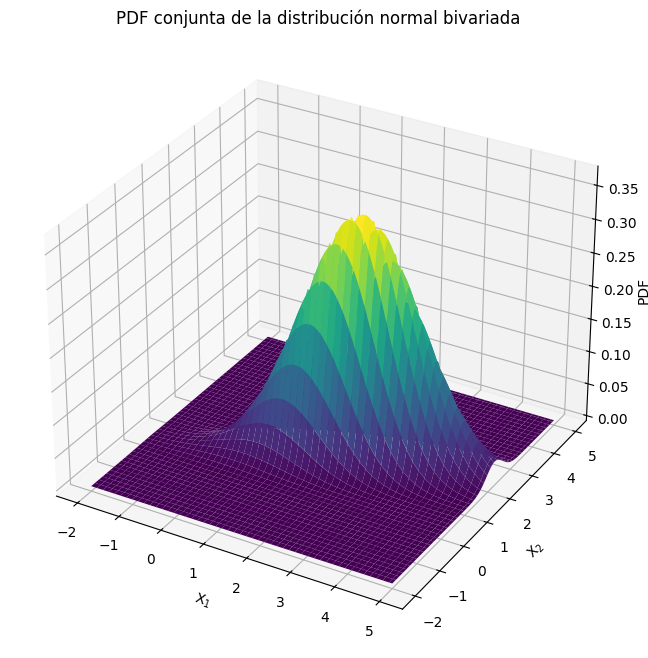

In [18]:
#defino funcion PDF conjunta (analiticamente) de una distribución normal bivariada

def bivariate_normal_pdf(x, y, mean, cov):
    """
    Función para calcular la PDF conjunta de una distribución normal bivariada.
    """

    # Vector de variables aleatorias
    xy = np.column_stack([x, y])

    # Diferencia entre las variables y las medias
    diff = xy - mean

    # Inversa de la matriz de covarianza
    inv_cov = np.linalg.inv(cov)

    # Exponencial
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)  #el simbolo @ lo usamos para multiplicar matrices

    # Normalización
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))


    pdf_values = constant * np.exp(exponent)

    return pdf_values


# Graficamos la superficie
fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot(111, projection='3d')


# Definimos el rango de valores para x e y
x = np.linspace(-2, 5, 100)
y = np.linspace(-2, 5, 100)
X, Y = np.meshgrid(x, y)

# Calculamos la PDF conjunta para cada combinación de (x, y) y la graficamos
Z = bivariate_normal_pdf(X.ravel(), Y.ravel(), mean_X, cov_X)
Z = Z.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap='viridis')

# Etiquetas y título
ax.set_xlabel('X$_1$')
ax.set_ylabel('X$_2$')
ax.set_zlabel('PDF', labelpad=2,rotation=90)

ax.set_title('PDF conjunta de la distribución normal bivariada')

plt.show()

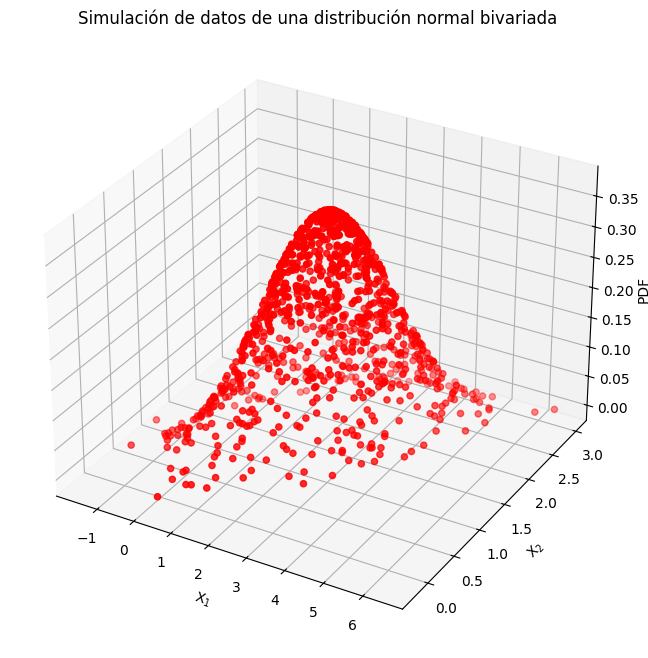

In [5]:
#hago simulacion montecarlo 1000 veces
data_X = multivariate_normal.rvs(mean_X, cov_X, size=nsim, random_state=rng)

#graficamos este caso:
fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos
ax.scatter(data_X[:, 0], data_X[:, 1], multivariate_normal.pdf(data_X, mean_X, cov_X), color='r')
ax.set_xlabel('X$_1$')
ax.set_ylabel('X$_2$')
ax.set_zlabel('PDF', labelpad=2,rotation=90)
ax.set_title('Simulación de datos de una distribución normal bivariada')
plt.show()

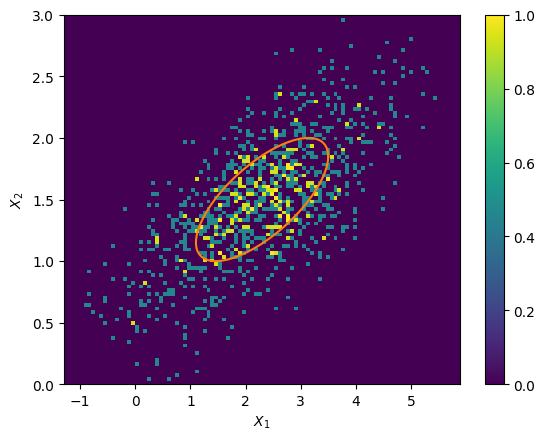

In [19]:
# Acá hacemos un histograma 2D con los datos simulados como el que hizo el profe
# en el video probabilidad3_clase4
fig, ax = plt.subplots()
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")

x1_limits = [mu1-3*sigma1, mu1+3*sigma1]
x2_limits = [mu2-3*sigma2, mu2+3*sigma2]

counts, xedges, yedges, im = ax.hist2d(data_X[:,0], data_X[:,1], range=[x1_limits, x2_limits], bins=100, density=True, cmap=cm.viridis, vmin=0, vmax=1)
clb = plt.colorbar(im)

ax.plot(*danatools.get_ellipse(mean_X, cov_X, nsigma=1), color='tab:orange')


Para calcular la fracción de eventos que caen dentro de la elipse $1\sigma$, se obtiene el valor de la forma cuadrática $Q = \left(\mathbf{x}-\mathbf{\mu}\right)^{T}\mathbf{A}\left(\mathbf{x}-\mathbf{\mu}\right)$ para cada $\left(x_{1},x_{2}\right)$ y se compara con $r=1$. Si $Q(x_{1},x_{2})\le1$, el evento se encuentra
contenido en la región $1\sigma$, mientras que si $Q(x_{1},x_{2})>1$, el evento cae fuera de la región.

In [20]:
# Acá vamos a calcular la fracción de eventos que caen dentro de la elipse
# Invertimos la matriz de covarianzas para obtener la matriz hessiana
hessian_matrix = linalg.inv(cov_X)

# Calculamos la forma cuadrática asociada Q para cada X
vectores_X = data_X - mean_X
Q = np.einsum('ij,ji->i', np.einsum('ij,jk->ik', vectores_X, hessian_matrix), vectores_X.T)

# Contamos la cantidad de valores de X que tienen Q<=1 y la dividimos por el total
fraccion = sum(Q<=1) / nsim
print("La fracción de eventos que caen dentro de 1sigma es:",fraccion)

La fracción de eventos que caen dentro de 1sigma es: 0.414


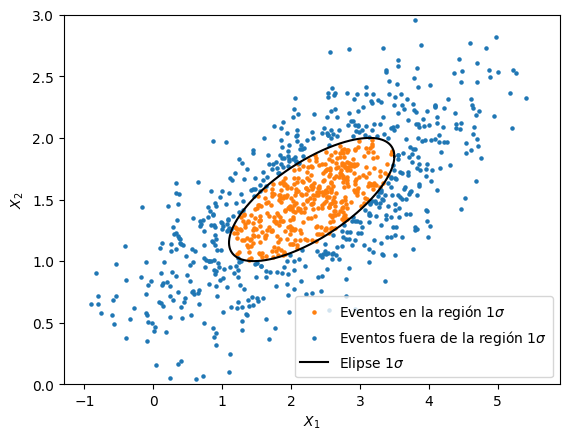

In [21]:
# Realizamos un gráfico para observar los eventos que caen dentro y fuera de la región
fig, ax = plt.subplots()
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")

x1_limits = [mu1-3*sigma1, mu1+3*sigma1]
x2_limits = [mu2-3*sigma2, mu2+3*sigma2]

plt.scatter(data_X[Q<=1,0], data_X[Q<=1,1], s=5, label='Eventos en la región $1\sigma$', color='tab:orange')
plt.scatter(data_X[Q>1,0], data_X[Q>1,1], s=5, label='Eventos fuera de la región $1\sigma$', color='tab:blue')
ax.plot(*danatools.get_ellipse(mean_X, cov_X, nsigma=1), color='black', label='Elipse $1\sigma$')
ax.set_xlim(x1_limits)
ax.set_ylim(x2_limits)
plt.legend()

In [9]:
# Elegimos 10 valores al azar para graficar
posiciones = np.random.default_rng(seed=6870).integers(low=0, high=nsim, size=10)

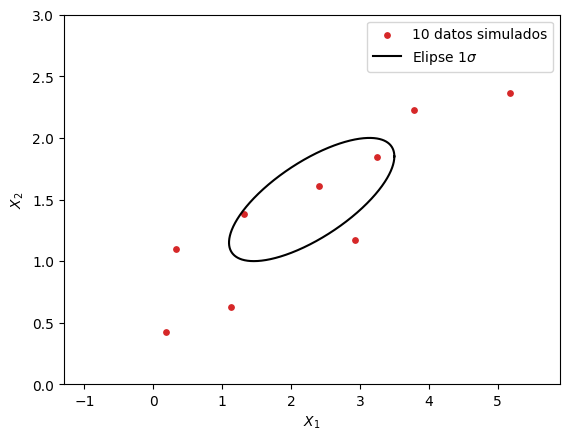

In [22]:
fig, ax = plt.subplots()
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")

x1_limits = [mu1-3*sigma1, mu1+3*sigma1]
x2_limits = [mu2-3*sigma2, mu2+3*sigma2]

plt.scatter(data_X[posiciones,0], data_X[posiciones,1], s=15, color='tab:red', label='10 datos simulados')
ax.plot(*danatools.get_ellipse(mean_X, cov_X, nsigma=1), color='black', label='Elipse $1\sigma$')
ax.set_xlim(x1_limits)
ax.set_ylim(x2_limits)
plt.legend()